# Identifying Whale Species From Whale Tails With Fastai

By Karl Heyer

This project will show my solution to Kaggle's [Humpback Whale Identification Challenge](https://www.kaggle.com/c/whale-categorization-playground). The goal of the project is to build a model that will predict a whale's species from a photo of a whale's tail. The competition is evaluated on a Mean Average Precision at 5 basis. For each image in the test dataset, the top five whale ID predictions will be submitted.

To build a solution to this challenge, we will take advantage of transfer learning from a pretrained model. We will take a resnet model pretrained on ImageNet data and fine tune it to the specific task of classifying whale species. 

## Acknowledgements 

Model structure and training was adapted from [Fastai Lesson 2](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb)

Processing the input data into a form that works well with Fastai was adapted from a notebook by [James Rees](https://github.com/jamesr2323/deep_learning/blob/master/experiments/whales_baseline.ipynb)

Some data exploration was adapted from a Kaggle kernel by [Lex Toumbourou](https://www.kaggle.com/lextoumbourou/humpback-whale-id-data-and-aug-exploration)

# Contents
1. Project Setup
    * 1.1 Import Libraries
    * 1.2 Load Data
    * 1.3 High Level Data Overview
2. Data Analysis
    * 2.1 Data Distribution
    * 2.2 Image Sizes
    * 2.3 Bounding Boxes
    * 2.4 Notes on Image Preparation
    * 2.5 Data Preparation
3. Model Setup
4. Model Training
5. Model Submission
6. Conclusions

# 1. Project Setup

## 1.1 Import Libraries

This project uses fastai, matplotlib, seaborn, PIL, pathlib, pickle, and the dependencies of these libraries

In [1]:
#Notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Import fast.ai library
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from matplotlib import patches, patheffects
from PIL.ImageDraw import Draw

These next two cells set the GPU that will be used and checks to make sure cuda and cudnn are enabled

In [3]:
#Set GPU
torch.cuda.set_device(1)
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

## 1.2 High Level Data Overview

The assumed file structure for this notebook is the same used by Kaggle. Training images are in a "train" directory. Test images are in a "test" directory. Training data labels are contained in the csv file "train.csv". Bounding box information for images is contained in the text file "cropping.txt". The bounding box information used in this notebook was taken from a [Kaggle Kernel by Martin Piotte](https://www.kaggle.com/martinpiotte/bounding-box-data-for-the-whale-flukes/notebook). The directories "tmp", "train_crop", and the file "train_int.csv" will be created in the notebook.

In [67]:
PATH = "data/Whale/"
os.listdir(PATH)

['.ipynb_checkpoints',
 'cropping.txt',
 'models',
 'sample_submission.csv',
 'test',
 'tmp',
 'train',
 'train.csv',
 'train_crop',
 'train_int.csv']

The "test" and "train" folders contain images for the test set and training set. Lets look at the format the train.csv file:

In [6]:
label_df = pd.read_csv(f'{PATH}train.csv')
label_df.head()

Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3

Each filename is associated with a coded whale ID. Lets look at some of the images in the training dataset:

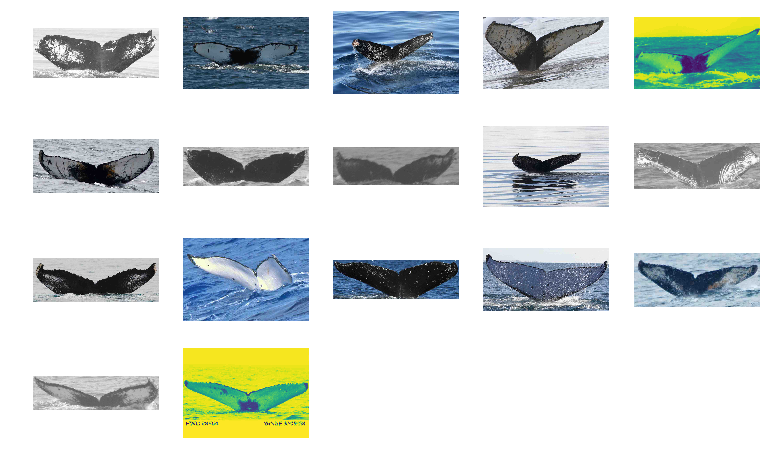

In [7]:
files = os.listdir(f'{PATH}train')[15:32]

figure = plt.figure(figsize=(13, 8))
cols = len(files) // 4 + 1

for i in range(len(files)):
    subplot = figure.add_subplot(4, cols, i+1)
    subplot.axis('Off')
    img = plt.imread(f'{PATH}train/{files[i]}')
    plt.imshow(img)

Already we can see some facets of the image dataset. Some images are in black and white. Some have other color augmentations. There is some variance in angle and rotation of the images. Some images have text at the bottom. Most images seem to be a rectangular image of the whale tail, but not all. This is expecially important given how the neural net expects a square input.

Lets start digging into the data a bit more.

# 2. Data Analysis

## 2.1 Data Distribution

Lets take a closer look at the label information to get an idea of how classes are represented.

In [8]:
len(label_df['Id'].unique())

4251

There are 4251 unique classes represented in the training set.

In [9]:
label_df.pivot_table(index='Id', aggfunc=len).sort_values('Image', ascending=False).head(10)

Image
Id              
new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_fd1cb9d     22
w_ab4cae2     22
w_693c9ee     22
w_987a36f     21
w_43be268     21

By far the most dominant class by count in the dataset is the "new_whale" category. I assume this is a catchall bucket for whales that cannot be clearly identified from the photo. This could be a problem for an image classifier, since it is likely that a number of whale types are represented in the "new_whale" category.

In [10]:
label_df.pivot_table(index='Id', aggfunc=len).sort_values('Image', ascending=False).tail(10)

Image
Id              
w_7d7d108      1
w_7d9642c      1
w_0ffc383      1
w_7dc3fae      1
w_7e253e1      1
w_7e48479      1
w_7e728d8      1
w_7e8305f      1
w_7e841fa      1
w_ffdab7a      1

There are also a large number of categories that only have a single example. This is also difficult for an image classifier, as it doesn't give much data to support each class.

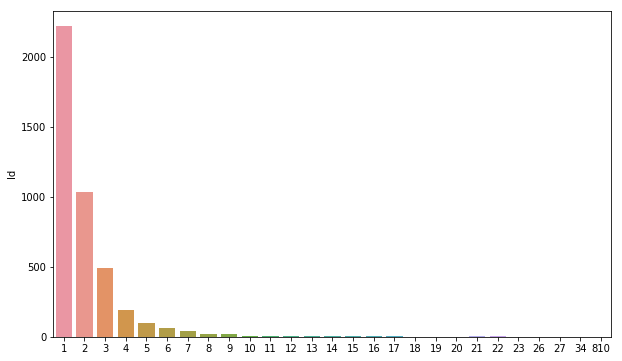

In [11]:
plt.clf()
plt.figure(figsize=(10,6))
g = sns.barplot(x=label_df['Id'].value_counts().value_counts().index, y=label_df['Id'].value_counts().value_counts())
plt.show()

From this plot we can see that over half of all categories in the dataset have only a single image representing them. The best way to deal with this is to use data augmentation to artificially expand the dataset.

## 2.2 Image Sizes

Lets see how the sizes of images are distributed in the dataset.

In [12]:
size_d = {k: PIL.Image.open(PATH+'train/'+k).size for k in label_df['Image']}

In [13]:
row_sz, col_sz = list(zip(*size_d.values()))

In [14]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([   2.,   25.,   49.,   84.,  180.,  219.,  801.,  427.,  513., 7550.]),
 array([  64. ,  162.6,  261.2,  359.8,  458.4,  557. ,  655.6,  754.2,  852.8,  951.4, 1050. ]),
 <a list of 10 Patch objects>)

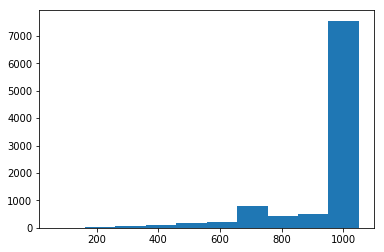

In [15]:
plt.hist(row_sz)

(array([ 209., 2249., 3000., 2820., 1533.,   17.,    8.,    2.,    3.,    9.]),
 array([  30. ,  188.3,  346.6,  504.9,  663.2,  821.5,  979.8, 1138.1, 1296.4, 1454.7, 1613. ]),
 <a list of 10 Patch objects>)

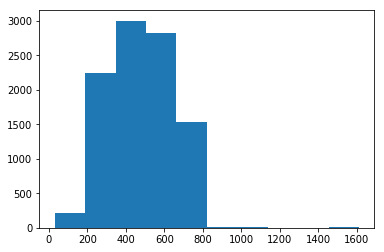

In [16]:
plt.hist(col_sz)

It looks like most images are rectangular, which is what we saw in the preview of images. Most images appear to be above 224x224 in size, which is what we want for using imagenet models.

## 2.3 Bounding Box Cropping

Kaggle user [Martin Piotte](https://www.kaggle.com/martinpiotte) was kind enough to provide bounding box information for 1200 images in the training dataset. We will use this information to crop images in the dataset to better focus the model on the whale tail itself, and not extraneous features like the ocean.

The bounding data is in the form of coordinate points that outline the whale tail in a given image.

In [61]:
with open(f'{PATH}cropping.txt', 'rt') as f: bounding_data = f.read().split('\n')[:-1]
len(bounding_data)

1199

In [62]:
for line in bounding_data[:5]: print(line)

88532e70.jpg,195,293,269,115,868,158,888,170,641,496,512,546,321,524
0c88a7aa.jpg,125,78,159,19,784,19,808,95,457,390
1442f41d.jpg,19,112,58,13,618,19,652,50,418,276,99,247
1b5f7f86.jpg,109,347,124,309,906,298,933,355,591,483,454,494
2cb0e816.jpg,38,230,77,193,950,198,990,245,705,469,513,484,343,443


In [63]:
bounding_data = [line.split(',') for line in bounding_data]
bounding_data = [(p,[(int(coord[i]),int(coord[i+1])) for i in range(0,len(coord),2)]) for p,*coord in bounding_data]
bounding_data[0] # First row of the dataset

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

We can plot these coordinate points on an image

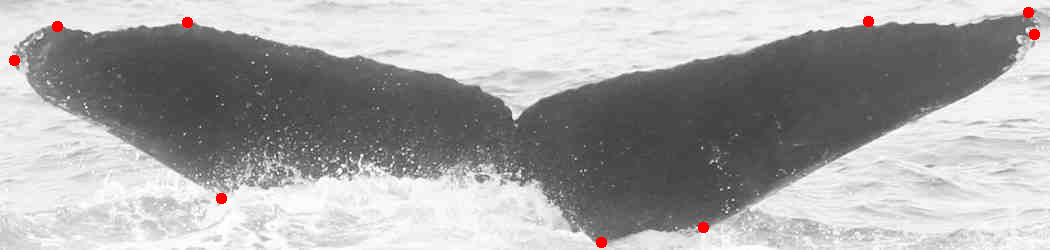

In [76]:
def read_raw_image(p):
    return PIL.Image.open(f'{PATH}train/{p}')

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

filename,coordinates = bounding_data[763]
img = read_raw_image(filename)
draw = Draw(img)
draw_dots(draw, coordinates)
img

We can use the outermost points to draw a bounding box around the whale tail

In [77]:
def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1

box = bounding_rectangle(coordinates)
box

(14, 12, 1034, 242)

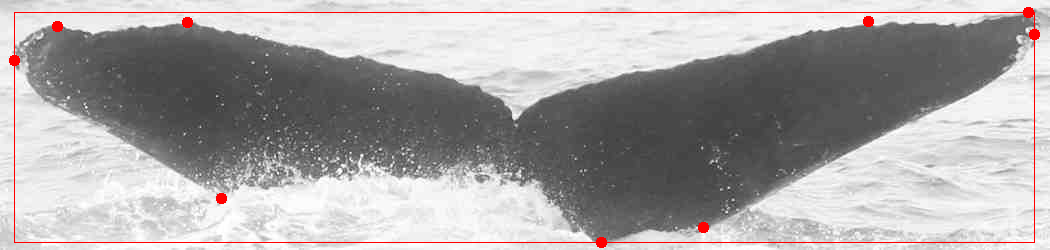

In [78]:
draw.rectangle(box, outline='red')
img

In [79]:
croppedIm = img.crop(box)

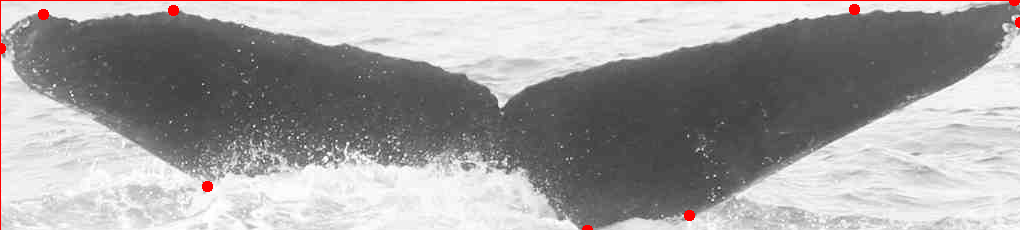

In [80]:
croppedIm

Now we loop through the coordinate data to bound and crop each image represented. The cropped images are saved into a directory "train_crop" which started as a duplicate of the training directory. This loop will overwrite each image represented in the bounding box data with a cropped version of that image.

One way I could have gone about this would be to make a second copy of the cropped images in the directory without deleting the original, so that image cropping would serve as a sort of augmentation on a portion of the training data. I decided not to do this. In experimenting around with different ways of upsampling low representation classes, one thing I tried was to create augmented duplicates of low representation images and add them to the training folder. This resulted in massively overfitting to the upsampled images. I was concerned that using cropping as a way of duplicating the images I have bounding box data for would lead to a similar result.

In [84]:
for i, (filename, coords) in enumerate(bounding_data):
    img = read_raw_image(filename)
    draw = Draw(img)
    draw_dots(draw, coords)
    box = bounding_rectangle(coords)
    draw.rectangle(box, outline='red')
    croppedIm = img.crop(box)
    croppedIm.save(f'{PATH}train_crop/{filename}')

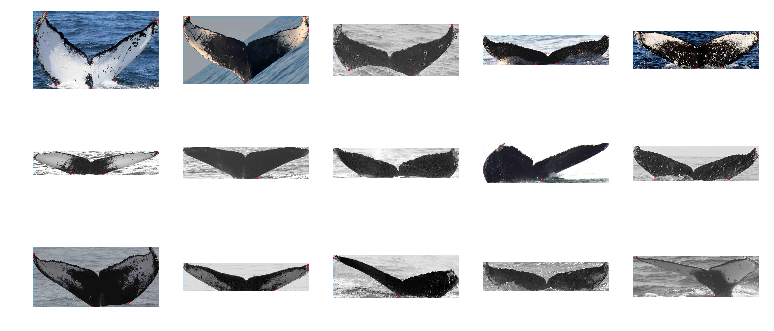

In [88]:
figure = plt.figure(figsize=(13, 8))
for i in range(15):
    filename = bounding_data[i][0]
    subplot = figure.add_subplot(4, 5, i+1)
    subplot.axis('Off')
    img = plt.imread(f'{PATH}train_crop/{filename}')
    plt.imshow(img)

## 2.4 Notes on Image Preparation

There is potential for more image preparation for this dataset. Bounding box cropping could be applied to all images in the training and test dataset. 

Color manipulation could also be applied to normalize the images to a single color scheme, instead of the multiple color schemes present in the dataset. One option would be to make every image black and white, or to make duplicate copies of each image in every color scheme present to expand the dataset. To do this in a way that works with imagenet models, the color augmented images would need to be a three channel image, and the function accomplishing the color augmentation would need to manage images in OpenCV to work with the fastai library.

There could also be performance improvements from upsampling classes with a single representative example. In working on this project, I experimented with this by duplicating low count classes to better represent them in training, but this just led to over fitting.

## 2.5 Data Preparation

[James Rees](https://github.com/jamesr2323/deep_learning/blob/master/experiments/whales_baseline.ipynb) found that replacing whale ID codes with integer keys worked better with fastai.

In [17]:
train_df = label_df
train_df['Id'] = train_df['Id'].astype('category')
whale_ids = train_df['Id'].unique()
whale_ids2num = {k: v for k,v in zip(whale_ids, range(len(whale_ids)))}
train_df['Id'] = train_df['Id'].map(whale_ids2num)
train_df.to_csv(f'{PATH}train_int.csv', index=False)

# 3. Model Setup

Now we'll go through the steps of setting up our model in fastai.

First we define sz - the image size we will train on, bs - the batch size used, and arch - the architecture we are going to build our model on.

We will train on 256x256 images. This is a good starting point as it is similar to the size of images the resnet model was trained on. The code shows "sz = 64" commented out. For fast iteration of model design, a small image size like 64x64 allows for quick training and experimentation. For running this notebook with the intent of developing a training protocol or making a submission, this should never be done. Training the resnet model on lower quality images can ruin well tuned parameters in the pre trained model.

We will train on a batch size of 32. This model could be trained on a larger batch size - I never ran into memory issues at this batch size - but I found the model converged faster with a smaller batch size.

The architecture we will build on is resnet34, developed by He et. al. (https://arxiv.org/abs/1512.03385). This model won 1st place on the ILSVRC 2015 classification task. 

In [18]:
#sz = 64
sz=256
arch=resnet34
bs=32


Lets look at the model:
This is a typical resnet model consisting of four relu blocks followed by average pooling and a linear output. The final linear layer outputs 1000 features for ImageNet classification. When we use this model with fastai, we will see how the final layers are replaced to account for a different number of classes in the whale dataset.

In [19]:
arch(True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

get_cv_idxs will select a random 20% of the training data to function as a validation set. Selecting a random sample might give a poor validation set for the whale data, considering how many classes have only a single image representing them. On the other hand, my intuition is that creating a validation set where only high representation classes are present would also give poor insight as to how the model is performing.

We will train with validation to develop a protocol to train the model to a point where we feel the model has converged without overfitting. Then we will repeat the exact training protocol without a validation set, allowing the model to train on the entire dataset.

In [20]:
n = len(list(train_df['Id']))-1
val_idxs = get_cv_idxs(n)

Now we will define the data augmentation we want to use from the fastai library. We will flip, rotate, and change the lighting of images in the dataset.

In [21]:
augs = [
    RandomFlip(),
    RandomLighting(0.1, 0.1),
    RandomRotate(10)
]

Here we set up our transformer to do our image augmentation and our dataloader to pass minibatches to the model.

In [22]:
tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

With our data loader set up, we will make a temporary copy of the image dataset where every image is resized to 375x375. This is to ensure we are not resizing a full size image every single time we want to run an image through a minibatch. This will also make every rectangular whale tail image square, ensuring the model can process the entire whale tail at once rather than taking a square cropped section.

In [23]:
data.resize(375,'tmp')

With the data loader set up, we can take a look at the image augmentation the dataset will use

In [24]:
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

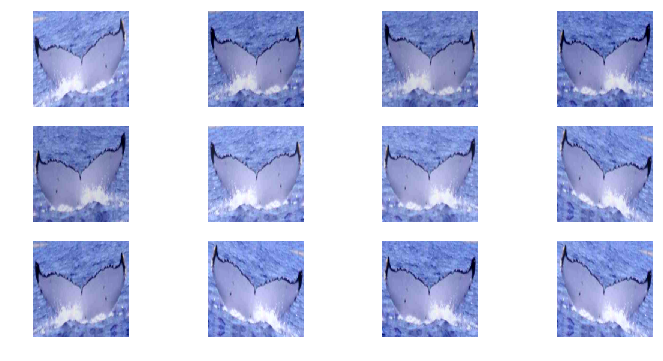

In [98]:
ims = np.stack([get_augs() for i in range(12)])
plots(ims, rows=3)

Here we can see the effect of both the data augmentations selected earlier and the square resizing of the image.

Finally we will prepare a function that computes the MAP@5 metric the competition uses for evaluation

In [25]:
def mpa_at_k(probs, y, k):
    probs_sorted = np.argsort(-probs,axis=1)[:,:k]
    matches = np.array([a == b for a,b in zip(probs_sorted,y)])
    return np.sum(matches * np.array([[1.0/x for x in range(1,k+1)]])) / len(y)

def mpa_at_5(probs, y):
    return mpa_at_k(probs, y, 5)

def mpa_at_5_pyt(probs, y):
    probs = probs.cpu().numpy()
    y=y.cpu().numpy()
    return mpa_at_5(probs, y)

# 4. Model Training

Now that we have our model selected, our image augmentations set, and our data loader created, it's time to train the model. First we are going to create our model using precompute=False. This will ensure image augmentation is used when training.

We are also going to use learn.freeze(). When fastai builds a learner from a pretrained model, it adds on several new layers after the pretrained layers that are randomly initialized. Setting learn.freeze() ensures that the pretrained layers are not updated in model training until learn.unfreeze() is called. The reason for doing this is to ensure the new, untrained layers don't cause accidentally hurt the well trained weights of the pretrained layers.

We will train for several epochs with pretrained layers frozen to get the new layers attuned to the dataset. Then we will unfreeze the precomputed layers and continue training.

In [26]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.freeze()

Lets look at the learner we created

In [27]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

Here we can see the layers added by fastai. The model now has an additional linear layer with batch normalization. The weights in these new layers are untrained, and will be used to fine tune the model to the specific task of identifying whales.

We will first perform several rounds of training on only these layers, keeping the back layers with pretrained weights unchanged. This is to prevent random quirks in the initial weights of the new layers from harming the well trained weights of the resnet model. After a few rounds of training, we will unfreeze the resnet layers and continue training.

To start training, we need to decide on a learning rate to use. To do this, we are going to use the learning rate finder in fastai, which will see how loss is affected by different learning rates.

 89%|█████████████████████████████████████████████████████████████▋       | 221/247 [01:04<00:07,  3.41it/s, loss=46.1]

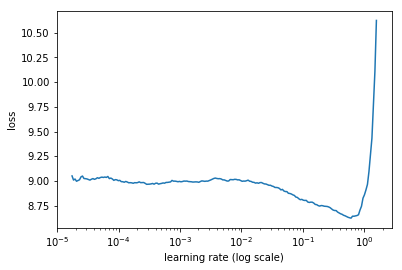

In [102]:
learn.lr_find()
learn.sched.plot()

For an initial learning rate, somewhere around 5e-2 looks good. While it might seem like the best option is to pick somewhere around 8e-1 where loss is minimized, this is very close to the point where the learning rate causes the model to diverge, and would be a bad choice. We will set cycle_len = 1 to have the model using stochastic gradient descent with restarts. This will decay the learning rate over the length of one cycle, and restart the decay for each subsequent cycle.

In [103]:
learn.fit(5e-2, 2, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      8.062414   7.789686   0.091849  
    1      7.373544   7.536627   0.101668                                                                              


[7.536626923562549, 0.10166751312002707]

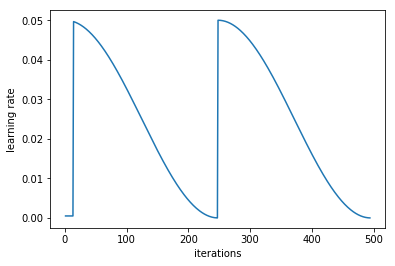

In [104]:
learn.sched.plot_lr()

Now we will unfreeze all layers and continue training. Also, instead of using a single learning rate, we will pass in an array of learning rates. This way we can train higher level layers at a higher learning rate than lower level layers. We also use cycle_mult to increase the number of epochs in a cycle.

In [105]:
learn.unfreeze()
lr = 5e-2
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      7.352597   7.453334   0.098891  
    1      7.004577   7.184713   0.114728                                                                              
    2      6.220043   7.026628   0.128432                                                                              
    3      6.492446   7.02633    0.118377                                                                              
    4      5.696405   6.740941   0.149678                                                                              
    5      4.916357   6.582278   0.179558                                                                              
    6      4.249026   6.570162   0.186262                                                                              


[6.570161702488812, 0.18626206196038597]

To illustrate the effect of cycle_len and cycle_mult, we can plot the learning rate over the batches run.

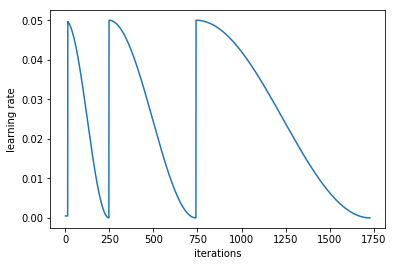

In [106]:
learn.sched.plot_lr()

To see how our model is performing, we can use data from the last convolutional layer to form a heatmap over am image to see what areas the model has determined are most important.

In [107]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [108]:
def plt_heatmap():
    
    m = nn.Sequential(*children(learn.model))
    figure = plt.figure(figsize=(20, 20))

    for i in range(9):
        subplot = figure.add_subplot(3, 3, i+1)
        subplot.axis('Off')

        x,y = next(iter(data.val_dl))
        x,y = x[None,i], y[None,i]
        vx = Variable(x.cuda(), requires_grad=True)
        dx = data.val_ds.denorm(x)[0]
        sfs = [SaveFeatures(o) for o in [m[-11][2]._modules['conv2']]]
        py = m(vx)
        for o in sfs: o.remove()
        feat = np.maximum(0,to_np(sfs[0].features[0]))
        vx = Variable(x.cuda(), requires_grad=True)
        py = np.exp(to_np(py)[0])
        params = list(m.parameters())
        weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
        f2=np.dot(np.rollaxis(feat,0,3), weight_softmax[0])
        f2-=f2.min()
        f2/=f2.max()
        plt.imshow(dx)
        plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');


c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


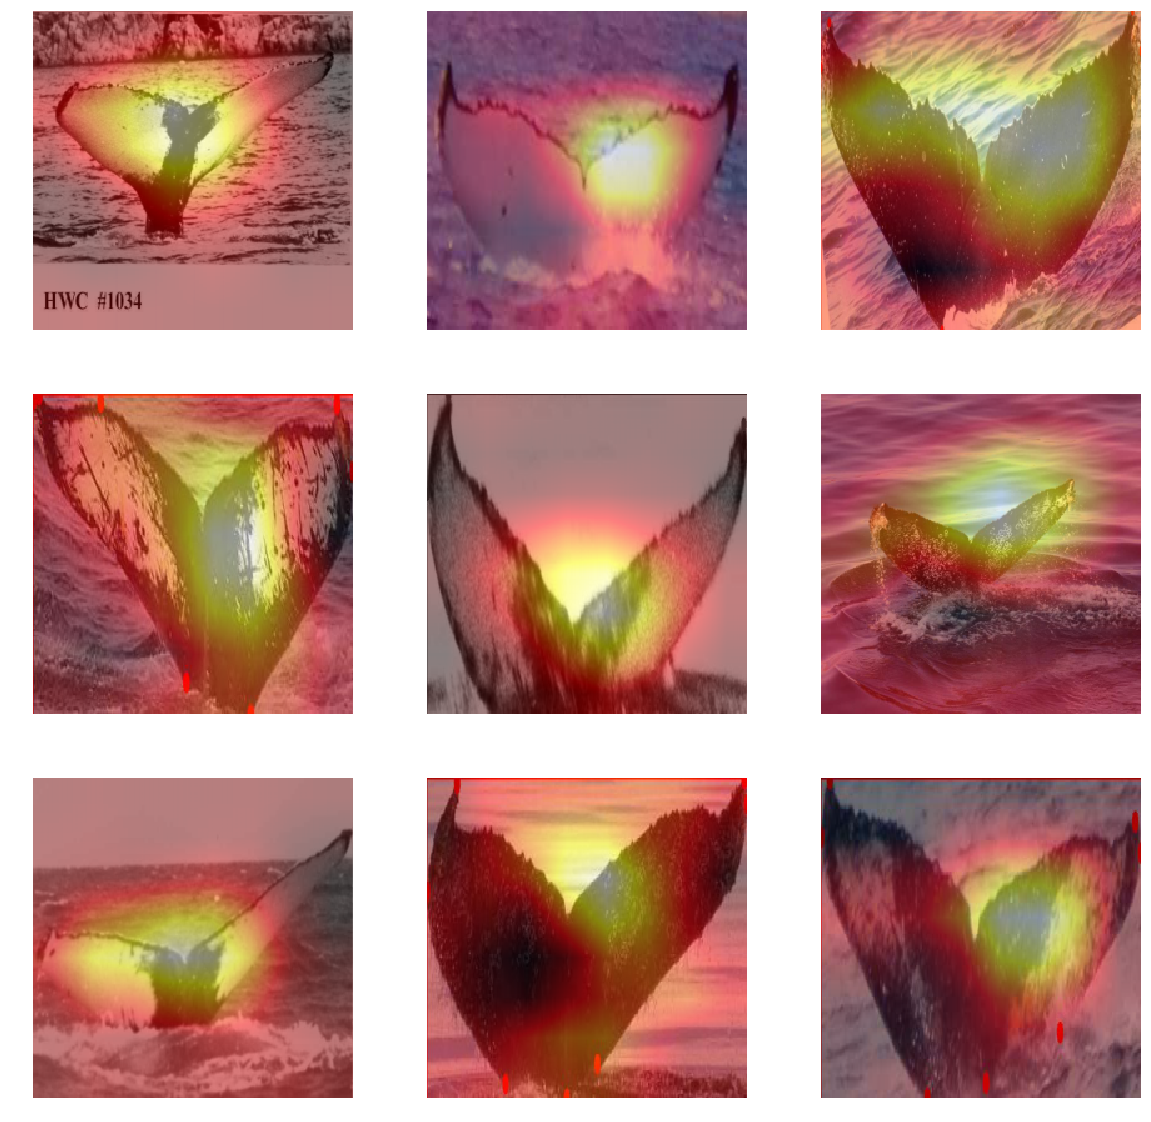

In [109]:
plt_heatmap()

The model seems to be identifying the whale tail in the image. Interestingly, in several of these examples only one side of the tail is flagged by the model.

The model began to overfit in the last few cycles of the previous training iteration. Now we load higher resolution images and repeat the training process. We do this by recreating the transformer and the data loader and then loading the new data loader into the learner.

In [110]:
learn.save('256_crop_train')

In [111]:
sz=299

tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

In [112]:
learn.set_data(data)

Again we use the learning rate finder to select a learning rate.

 88%|████████████████████████████████████████████████████████████▌        | 217/247 [01:39<00:13,  2.19it/s, loss=17.2]

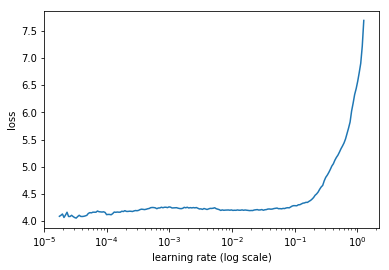

In [113]:
learn.lr_find()
learn.sched.plot()

In [114]:
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      4.191496   6.629223   0.184925  
    1      4.134839   6.620377   0.1989                                                                                
    2      3.783493   6.609864   0.20011                                                                               


[6.609864160577436, 0.2001100389368546]

In [115]:
learn.unfreeze()
lr = 1e-2
lrs = np.array([lr/6,lr/3,lr]) # We want to train lower layers a fair bit to specialise towards whale-tail specific features
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      3.851643   6.586595   0.205629  
    1      3.730628   6.568567   0.216362                                                                              
    2      3.359847   6.559469   0.225817                                                                              
    3      3.472318   6.582445   0.231683                                                                              
    4      3.091935   6.54878    0.247444                                                                              
    5      2.739484   6.492719   0.257178                                                                              
    6      2.538118   6.521531   0.26075                                                                               


[6.521531426404079, 0.26074995767733194]

That seems like sufficient training at this image size. Lets check the heatmap.

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


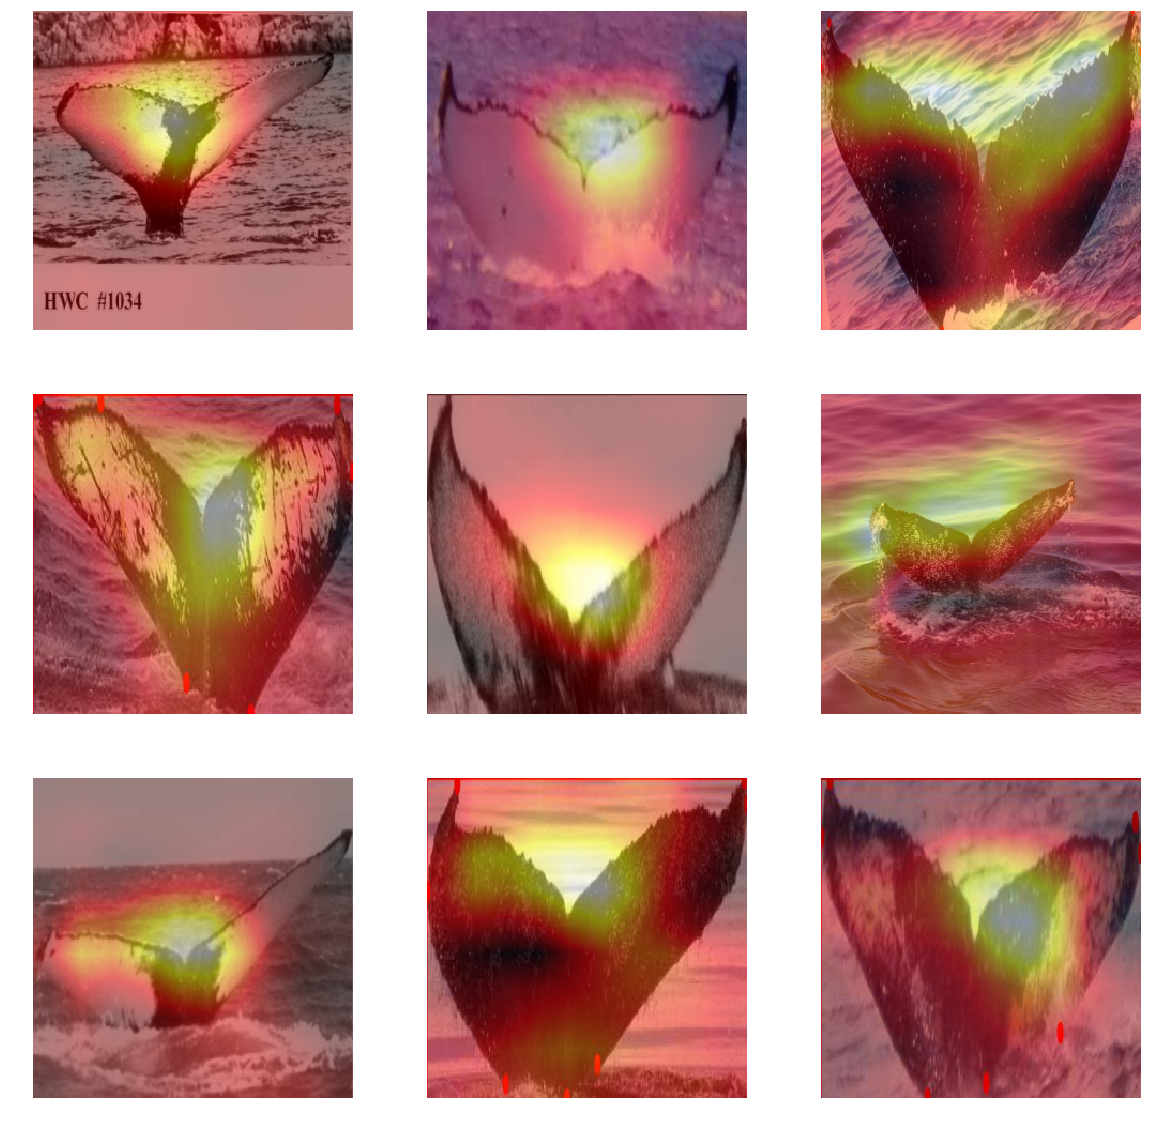

In [116]:
plt_heatmap()

It looks like the model has better identified the whale tail. Now we see oblong shapes around the top of the whale tail where the image transitions from whale to water. In some of these images, it looks like the horizon is flagged hotter relative to the rest of the ocean background. This might be an extraneous feature the model is picking up.

In [117]:
learn.save('299_crop')
#learn.load('299_heat')

Now another training iteration with 340x340 images

In [121]:
sz=375

tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

In [122]:
learn.set_data(data)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.036674   7.537498   0.131031  


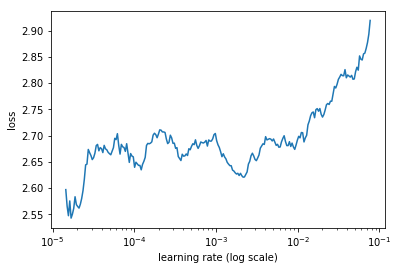

In [125]:
learn.lr_find(start_lr=1e-05, end_lr=1e-1)
learn.sched.plot()

In [126]:
learn.fit(5e-3, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      2.751184   6.649991   0.250161  
    1      2.715852   6.658915   0.255629                                                                              
    2      2.470471   6.667815   0.253547                                                                              


[6.667815094129757, 0.25354663958015916]

In [127]:
learn.unfreeze()
lr = 5e-3
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      2.566401   6.601939   0.270518  
    1      2.445009   6.612137   0.274463                                                                              
    2      2.161928   6.628592   0.274209                                                                              


[6.628592447074553, 0.2742085661080074]

In [128]:
lr = 1e-3
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      2.133896   6.58833    0.280159  
    1      2.008631   6.562199   0.282072                                                                              
    2      1.987084   6.609035   0.284908                                                                              


[6.609034796182488, 0.28490773658371427]

In [129]:
lr = 1e-4
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      2.031836   6.594434   0.283156  
    1      2.05894    6.594104   0.283029                                                                              
    2      1.979465   6.579295   0.281133                                                                              


[6.579295034151866, 0.28113255459624176]

This looks like a good place to stop. Before moving on, lets look into how the model has classified whales. First another heatmap:

c:\users\gateway\anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


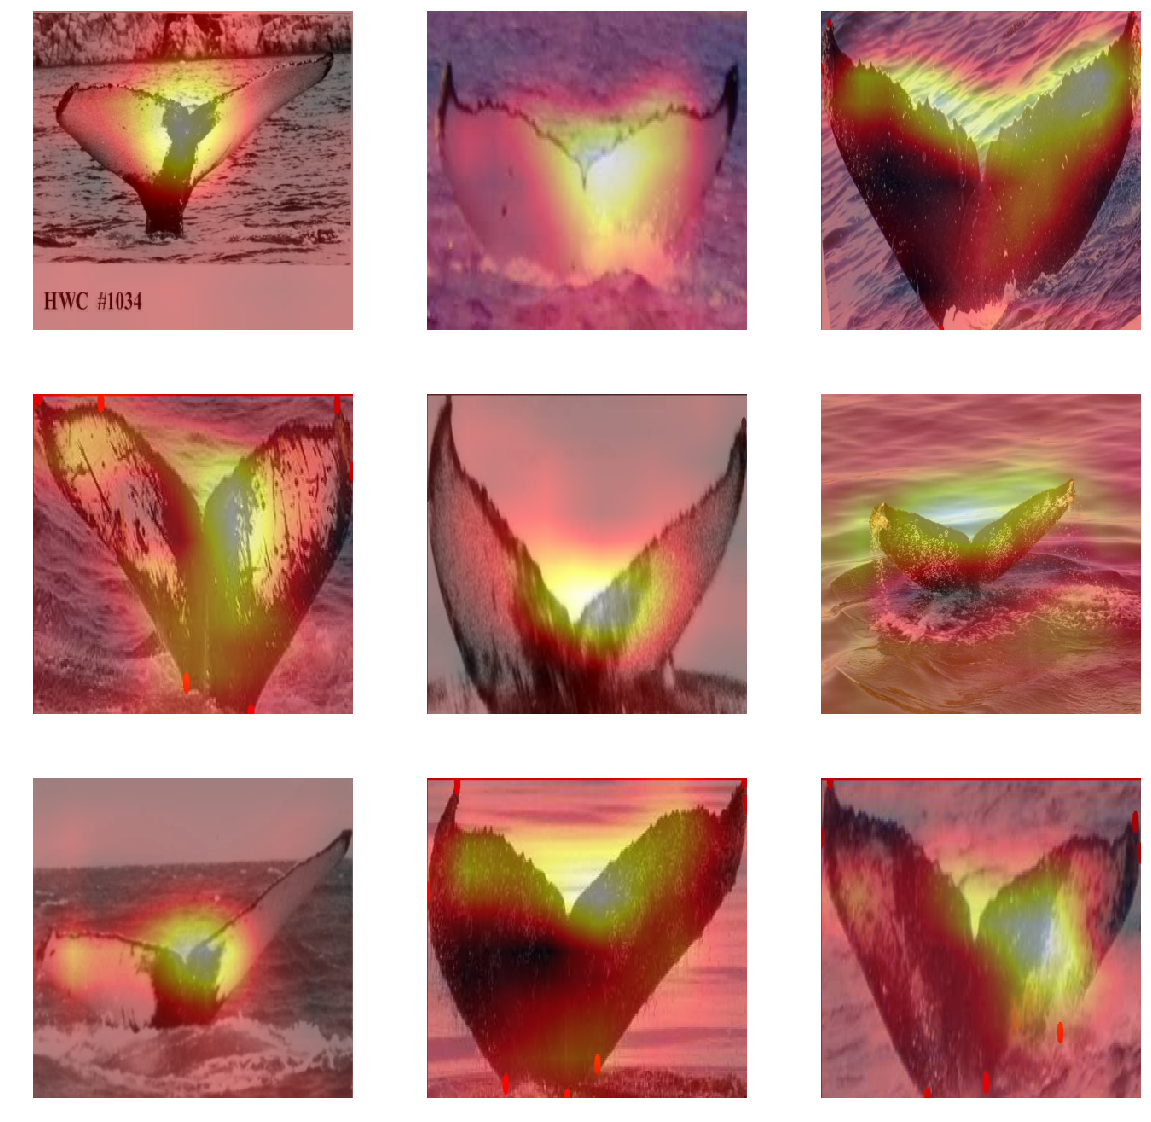

In [130]:
plt_heatmap()

In [131]:
learn.save('375_crop')

We can use the model to predict from the validation set, which will give us the probabilities for a given image belonging to a given class. We can use TSNE to decompose this information and plot it in two dimensions to visualize classification in another way. First we predict on the validation set with learn.TTA(). This function uses image augmentation in prediction. For each image in the validation set, the model will make predictions on five versions of the image (the original image and four augmentations). We can then average the prediction to get a vector of predictions for each image.

In [132]:
multi_preds, y = learn.TTA()
multi_preds.shape

(5, 1969, 4251)

Fastai returns the log of the predictions.

In [133]:
preds = np.mean(multi_preds, 0)
preds[0]

array([-13.87719, -11.55638, -19.04239, ..., -15.83757,  -9.78792, -21.82522], dtype=float32)

In [134]:
probs = np.exp(preds)
probs.shape

(1969, 4251)

Now to use TSNE to decompose the data into two dimensions

In [135]:
probs_embedded = TSNE(n_components=2).fit_transform(probs)

In [136]:
prob_df = label_df['Id'][val_idxs].copy()
prob_df = prob_df.reset_index()
prob_df.drop(['index'], inplace=True, axis=1)
num2whale = [k for k,v in whale_ids2num.items()]

prob_df = pd.concat([prob_df, pd.Series([num2whale[i] for i in prob_df['Id']]), 
                     pd.DataFrame(probs_embedded, columns=['x','y'])], axis=1)
prob_df.head()

Id          0          x          y
0     7  new_whale  19.507505  22.721870
1  1732  w_2dea395 -12.848057   2.075659
2  2144  w_8575984  17.043360  15.100622
3  3666  w_652e069   7.229141  19.293638
4  1503  w_6361632  -0.162522  21.452463

In [137]:
prob_df.shape

(1969, 4)

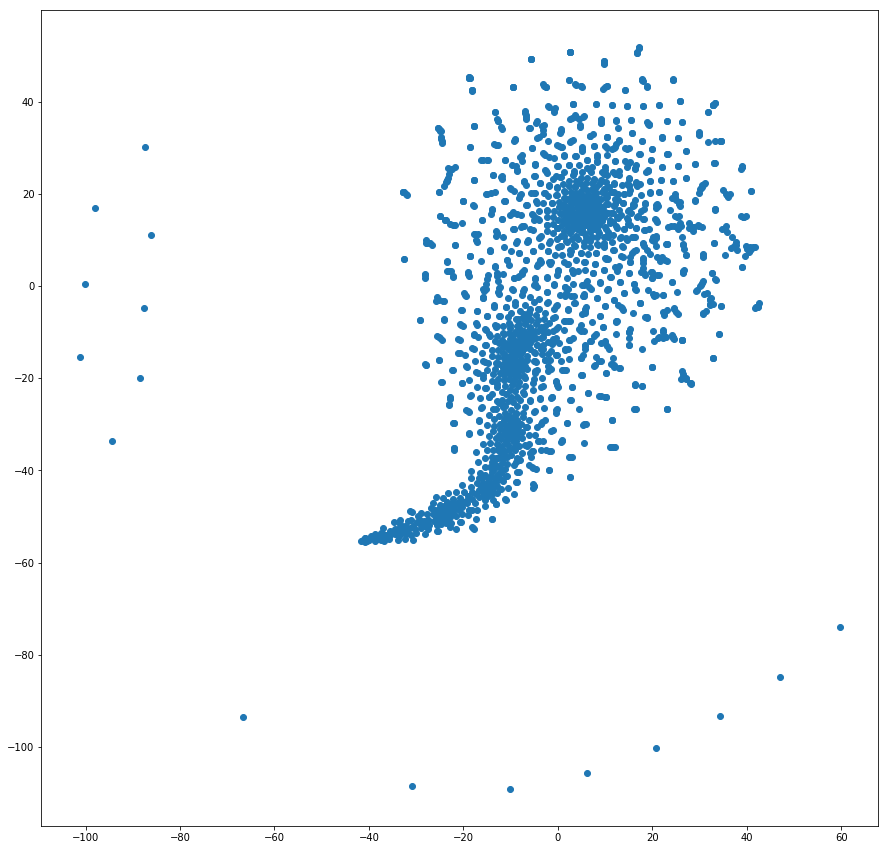

In [138]:
plt.figure(figsize=(15,15))
plt.scatter(prob_df['x'],prob_df['y'])

There is some indication of clusters forming, but there does not seem to be definitive distinctions between classes in the TSNE plot. Usually a plot like this has datapoints color coded by class. I decided not to do that due to the relative number of classes and images representing classes. The amount of single image classes in the dataset makes a class color coded version of the TSNE plot unreadable.

# 5. Model Submission

Now we're going to run the exact same training program on the entire dataset. We do this by assigning only two values to our validation indicies. It is important to note that because we don't have a real validation set, the numbers displayed for validation loss and mpa_at_5 are no longer representative of anything meaninfgul.

In [139]:
#sz = 64
sz=256
arch=resnet34
bs=32

val_idxs=[0,1]

tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

data.resize(375,'tmp')

In [140]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.freeze()

 89%|███████████████████████████████████████████████████████████████▏       | 274/308 [01:19<00:09,  3.43it/s, loss=38]

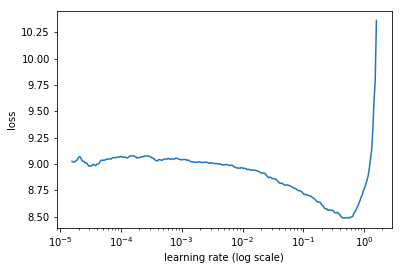

In [141]:
learn.lr_find()
learn.sched.plot()

In [142]:
learn.fit(5e-2, 2, cycle_len=1, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      7.951977   7.707134   0.0       
    1      7.305288   8.028811   0.0                                                                                   


[8.028810501098633, 0.0]

In [143]:
learn.unfreeze()
lr = 5e-2
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      7.16499    7.325258   0.0       
    1      6.859594   6.027592   0.5                                                                                   
    2      6.055382   5.913881   0.5                                                                                   


[5.913880825042725, 0.5]

In [144]:
sz=299

tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

In [145]:
learn.set_data(data)

In [146]:
learn.freeze()
learn.fit(1e-2, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      5.759945   5.966991   0.5       
    1      5.66972    5.844472   0.5                                                                                   
    2      5.268946   5.864948   0.5                                                                                   


[5.864948272705078, 0.5]

In [147]:
learn.unfreeze()
lr = 1e-2
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      5.336902   5.16055    0.5       
    1      5.179435   5.355075   0.5                                                                                   
    2      4.775122   5.061868   0.5                                                                                   
    3      4.963088   4.847842   0.5                                                                                   
    4      4.412632   5.574371   0.5                                                                                   
    5      4.086882   4.919235   0.5                                                                                   
    6      3.891402   4.990084   0.5                                                                                   


[4.990083694458008, 0.5]

In [148]:
sz=375

tfms = tfms_from_model(arch, sz, aug_tfms=augs, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, 'train_crop', f'{PATH}train_int.csv', test_name='test',
                                      val_idxs=val_idxs, tfms=tfms, bs=bs)

In [149]:
learn.set_data(data)

In [150]:
learn.fit(5e-3, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      3.970788   5.434018   0.5       
    1      3.960831   5.456331   0.5                                                                                   
    2      3.630925   5.255765   0.5                                                                                   


[5.255765438079834, 0.5]

In [151]:
learn.unfreeze()
lr = 5e-3
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      3.603008   5.367771   0.5       
    1      3.643179   5.231323   0.5                                                                                   
    2      3.295648   5.090969   0.5                                                                                   


[5.090968608856201, 0.5]

In [152]:
lr = 1e-3
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      3.179933   5.061782   0.5       
    1      3.179032   5.130064   0.5                                                                                   
    2      3.156957   5.224833   0.5                                                                                   


[5.224832534790039, 0.5]

In [153]:
lr = 1e-4
lrs = np.array([lr/6,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, metrics=[mpa_at_5_pyt])

epoch      trn_loss   val_loss   mpa_at_5_pyt                                                                          
    0      3.102335   5.141063   0.5       
    1      3.042835   5.202724   0.5                                                                                   
    2      2.996155   5.322953   0.5                                                                                   


[5.322953224182129, 0.5]

In [28]:
#learn.save('375_crop_final')
learn.load('375_crop_final')

Now we will use our model to predict on the test set. We will use the TTA function to use image augmentation during testing. Then we will process the output into the top five predictions, paired with the original whale id code.

In [29]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

In [157]:
probs_sorted = np.argsort(-mean_probs,axis=1)[:,:5] 

fnames = [f[5:] for f in data.test_ds.fnames]

In [158]:
num2whale = [k for k,v in whale_ids2num.items()]

def probs2whale(x):
    return num2whale[int(data.classes[x])]

probs2whale = np.vectorize(probs2whale)

def join_with_spaces(arr):
    return ' '.join(arr)

whales = np.apply_along_axis(join_with_spaces, 1, probs2whale(probs_sorted))

df = pd.DataFrame({'Image': fnames, 'Id': whales}, columns=['Image','Id'])
df.to_csv('humpback_submission_crop.csv', index=False)

In [30]:
mean_probs.shape

(15610, 4251)

Lets look at a TSNE representation of the test set predictions. To make this computationally feasible, lets select a random 2000 points.

In [41]:
t_idxs = np.random.choice(mean_probs.shape[0], 2000)
t_probs = mean_probs[t_idxs]
t_probs.shape

(2000, 4251)

In [42]:
preds = np.exp(t_probs)

In [63]:
probs_embedded = TSNE(n_components=2).fit_transform(preds)

In [64]:
prob_df = label_df['Id'][val_idxs].copy()
prob_df = prob_df.reset_index()
prob_df.drop(['index'], inplace=True, axis=1)
num2whale = [k for k,v in whale_ids2num.items()]

prob_df = pd.concat([prob_df, pd.Series([num2whale[i] for i in prob_df['Id']]), 
                     pd.DataFrame(probs_embedded, columns=['x','y'])], axis=1)
prob_df.head()

Id          0          x          y
0     7.0  new_whale   2.216113  35.496231
1  1732.0  w_2dea395  -6.915641  32.604382
2  2144.0  w_8575984  30.419201  39.582150
3  3666.0  w_652e069  31.797504 -29.339720
4  1503.0  w_6361632  33.916222   1.250197

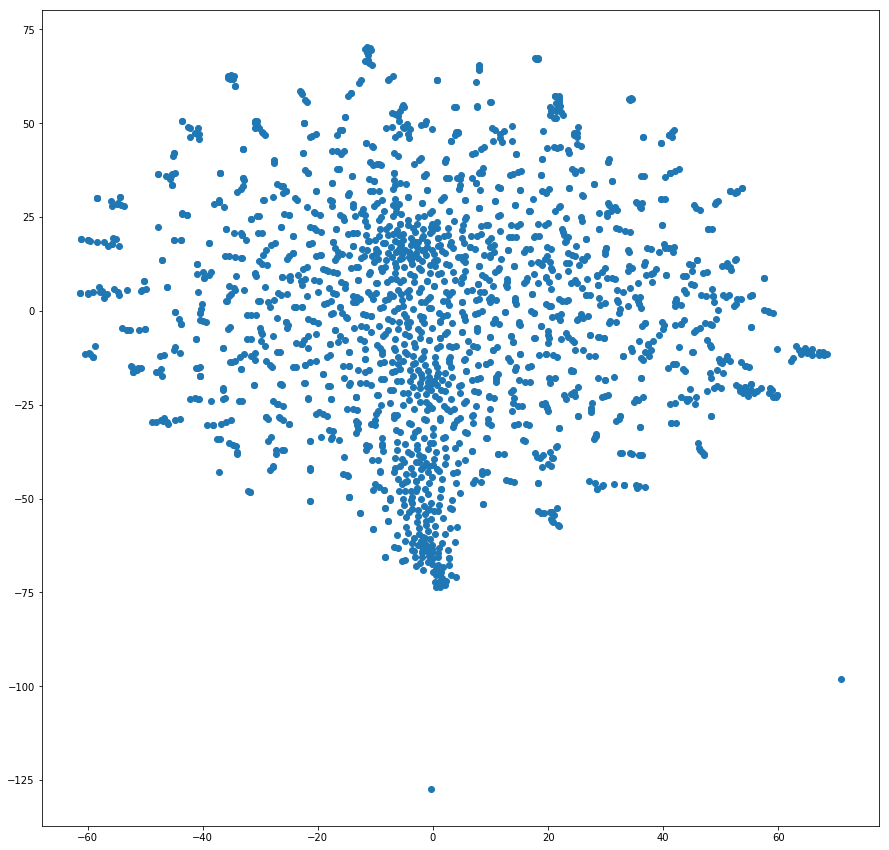

In [65]:
plt.figure(figsize=(15,15))
plt.scatter(prob_df['x'],prob_df['y'])

We see a similar pattern to the validation set TSNE

# Conclusions

The prediction from the model scored an MPA@5 of 0.43836 in the competition, putting it in the top 12%. I really enjoed working on this competition and I'm looking forward to doing more image classification projects in the future.